In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Cristóvão Beirão da Cruz e Silva <cbeiraod@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

#############################################################################
# Modified for ETROC2 I2C testing in jupyter notebooks, Murtaza Safdari
#############################################################################

## Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir('/home/daq/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import pickle
from pathlib import Path

## Set defaults

In [2]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM1"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [3]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [4]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [5]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

## Useful Functions

In [7]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

# Pixel ID Check

In [8]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [9]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

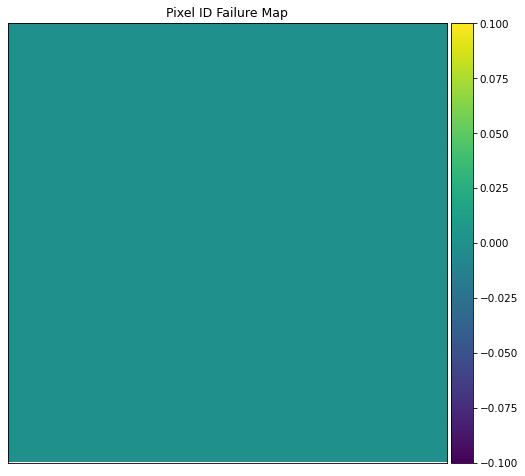

In [10]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

## Set Peripheral Registers

In [11]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))
peripheral_decoded_register_write("singlePort", '1')
peripheral_decoded_register_write("serRateLeft", '00')
peripheral_decoded_register_write("serRateRight", '00')
peripheral_decoded_register_write("onChipL1AConf", '00')
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))
# peripheral_decoded_register_write("fcClkDelayEn", "1")

## Set Current Mode

In [44]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")

# current_mode = 7  # Low current
current_mode = 0  # High current


for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)

        # Set current mode
        pixel_decoded_register_write("IBSel", format(current_mode, '03b'))

 row: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


## Automatic threshold calibration

In [45]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

In [41]:
# Reset output, active low
peripheral_decoded_register_write("asyResetGlobalReadout", '0')
peripheral_decoded_register_write("asyResetGlobalReadout", '1')

In [38]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(3)
row_indexer_handle.set(3)

print(pixel_decoded_register_read("IBSel", "Config"))
print(pixel_decoded_register_read("DAC", "Config"))

0x7
0x000


In [46]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("Bypass_THCal", "1")

In [47]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        
        pixel_decoded_register_write("DAC", format(0, '010b'))
        pixel_decoded_register_write("Bypass_THCal", "1")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))
        time.sleep(0.1)

 row: 100%|██████████| 16/16 [02:41<00:00, 10.08s/it]


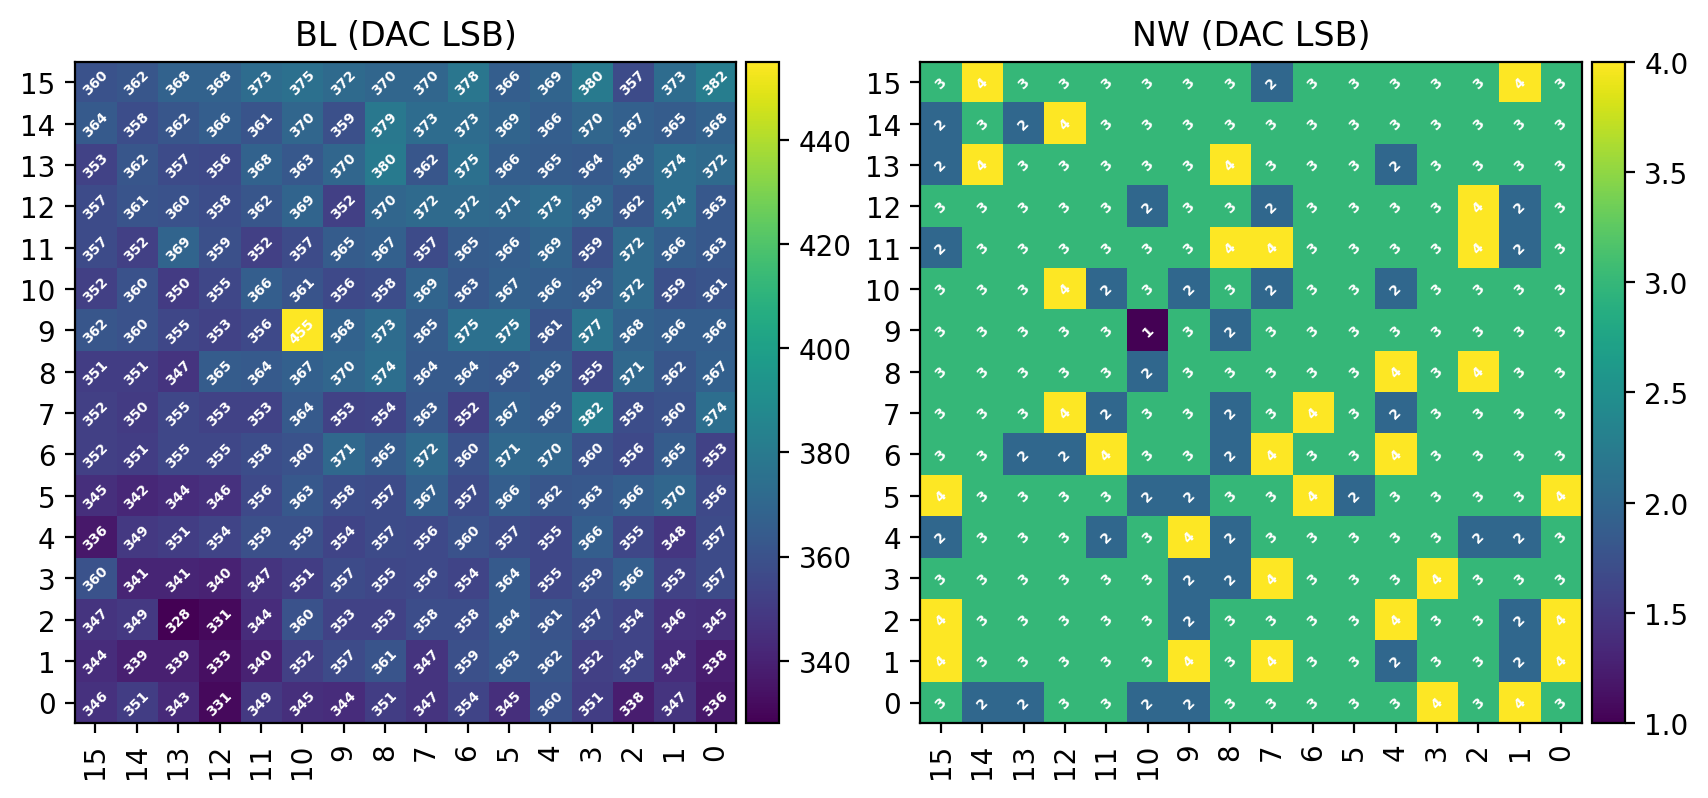

In [48]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

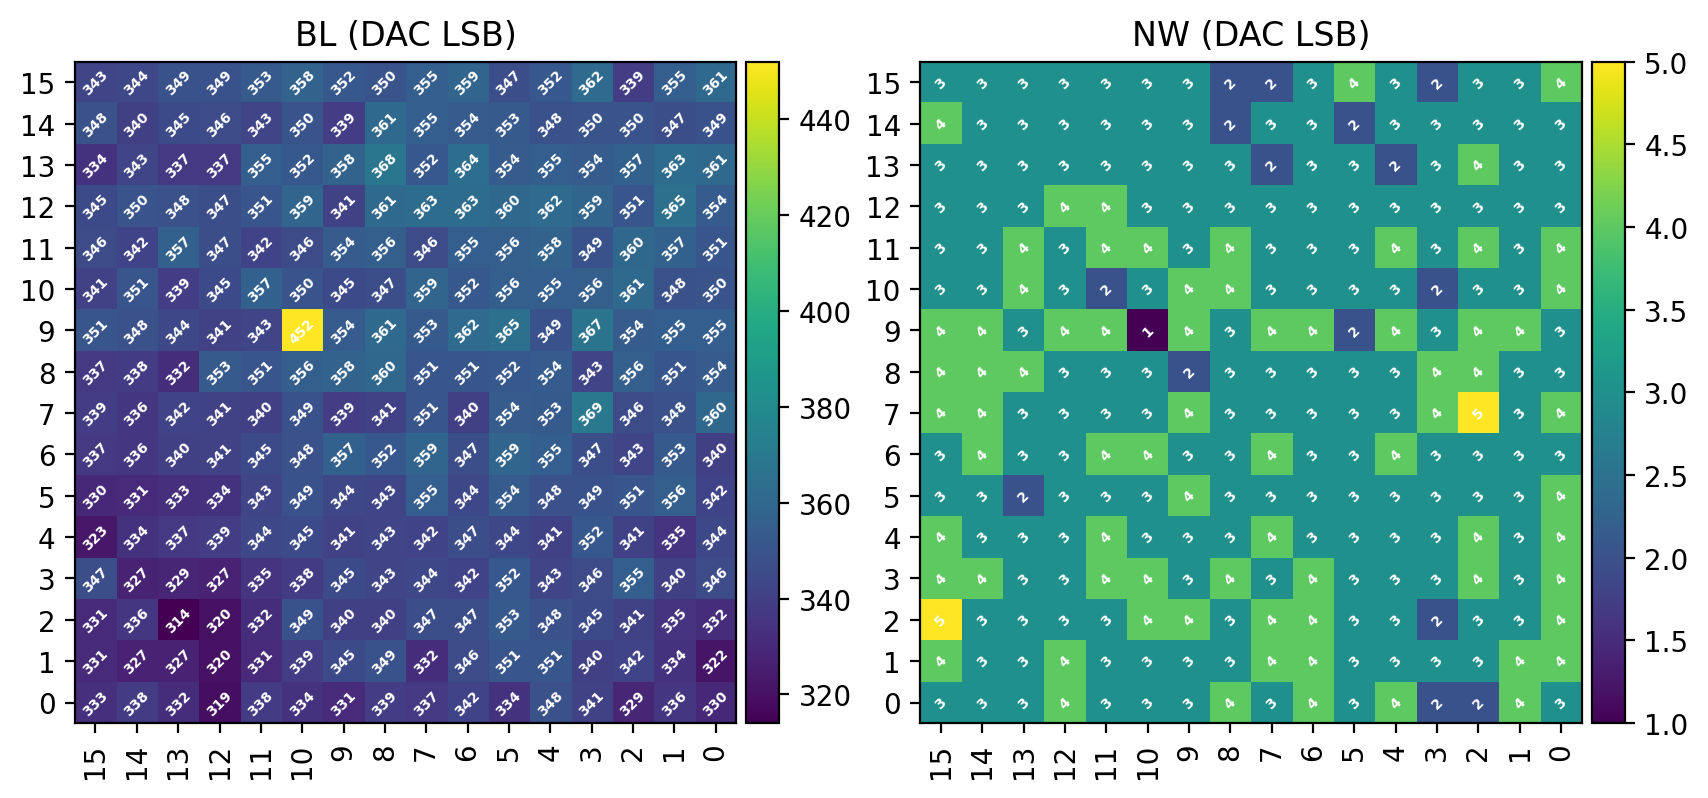

In [19]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

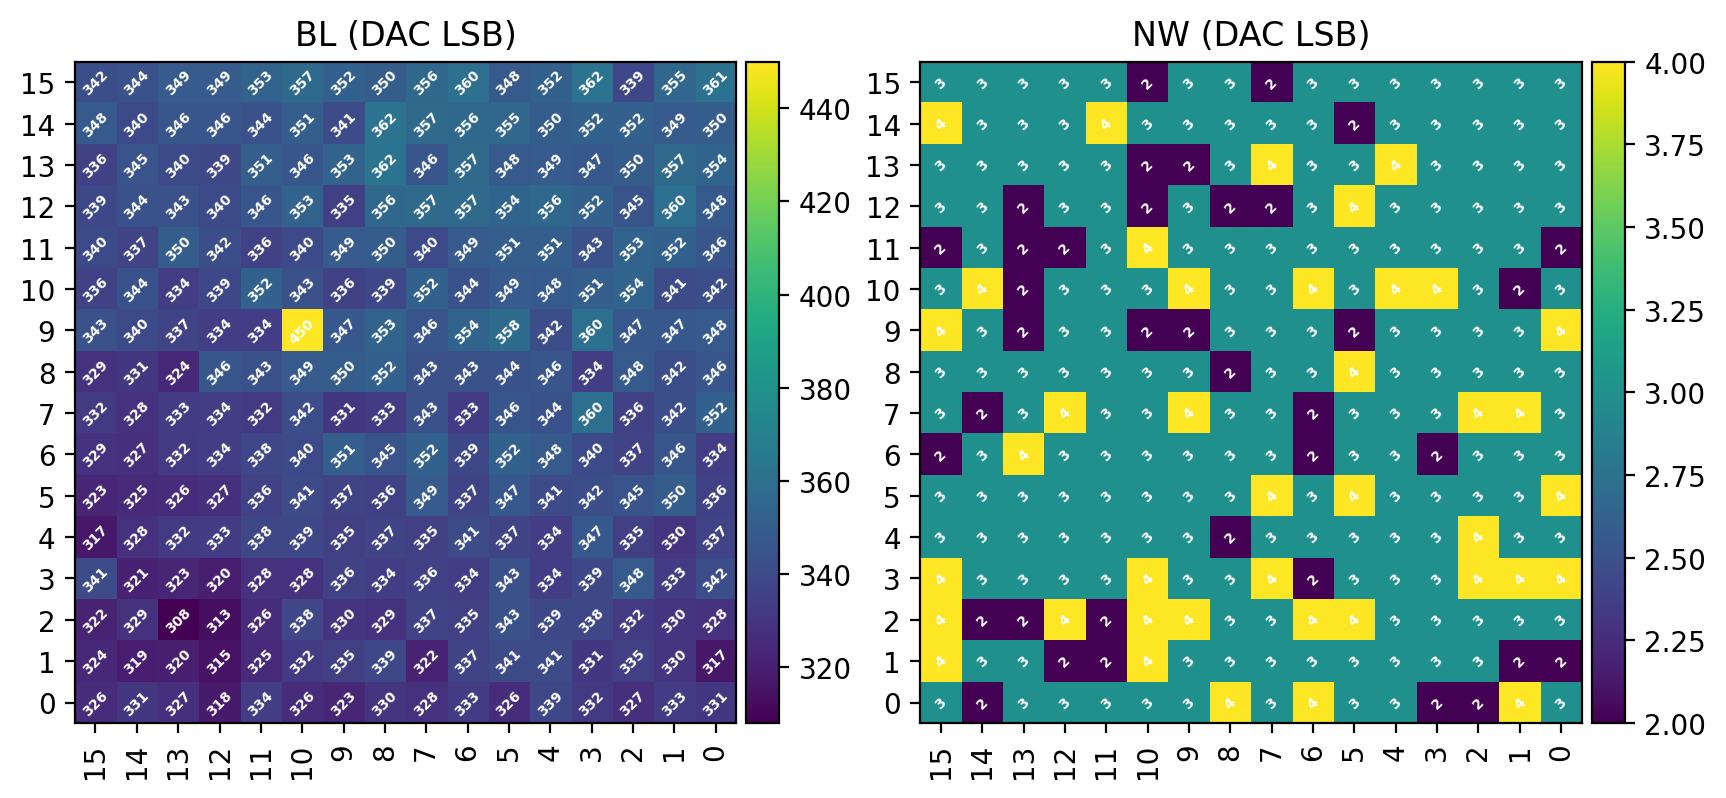

In [21]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

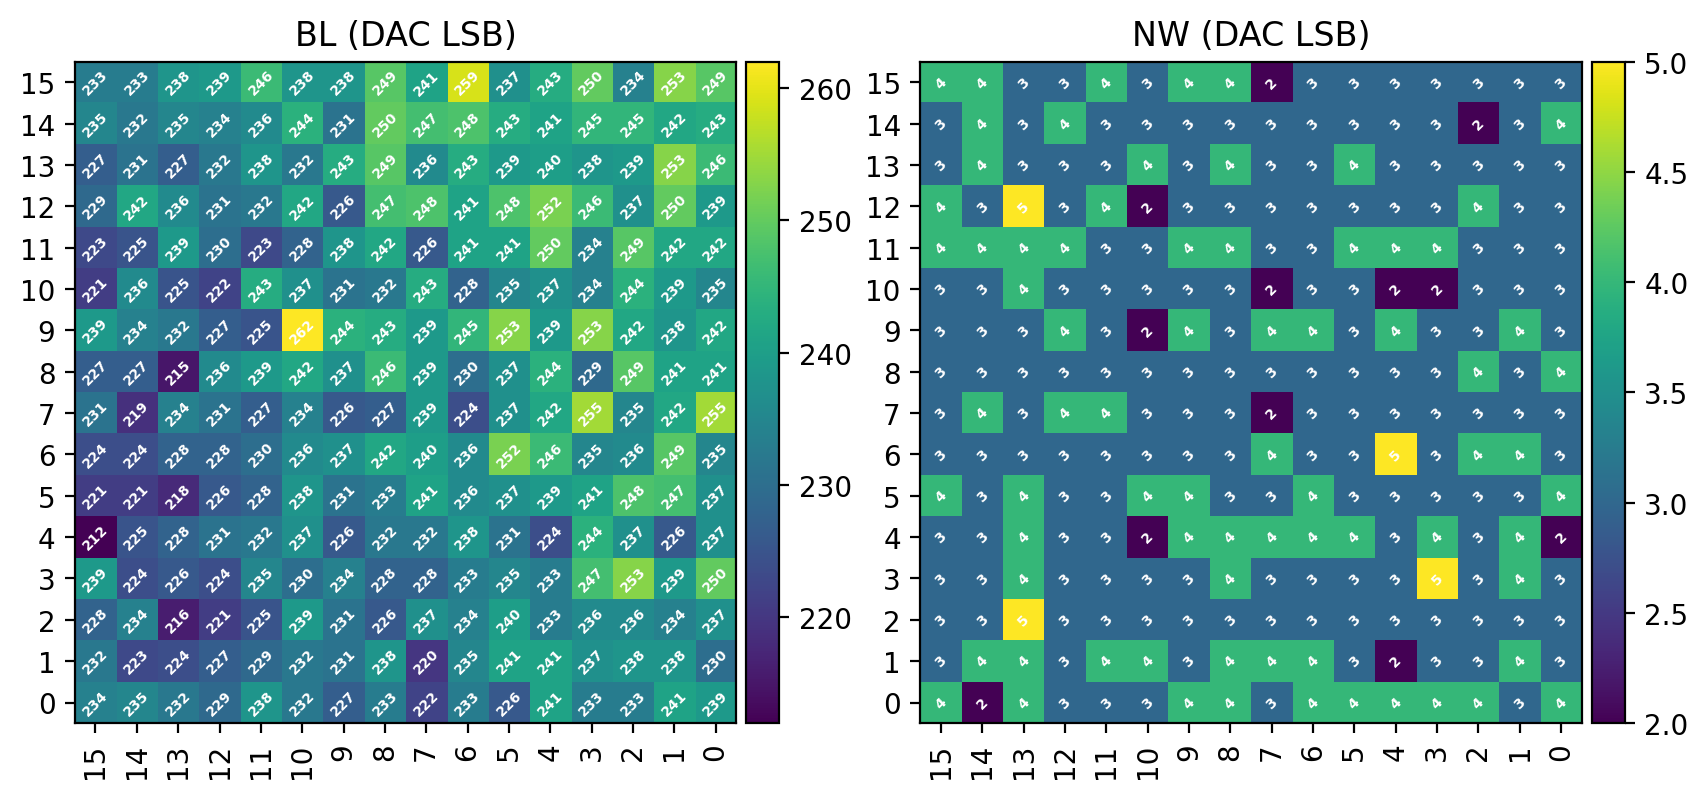

In [41]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

### Disable all pixels

In [49]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")

### Define pixels of interest

In [24]:
# Diagnoal scan
# col_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[1:-1])
# row_list = list(np.arange(16)[1:-1]) + list(np.arange(16)[::-1][1:-1])

# Box scan
# col_list = list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:]) + list(np.full(15, 0))
# row_list = list(np.full(15, 0)) + list(np.arange(16)[0:-1]) + list(np.full(15, 15)) + list(np.arange(16)[1:])

# Cluster scan
# col_list = [3, 3, 3, 12, 12, 12]
# row_list = [3, 8, 13, 3, 8, 13]

#row_list = list(np.arange(4)[0:])
#col_list = np.zeros_like(row_list)
row_list = [3,12,3,12]
col_list = [3,3,12,12]
# row_list = [3,12]
# col_list = [3,3]
#row_list = [3]
#col_list = [3]
# print(col_list)
# print(row_list)
scan_list = list(zip(col_list, row_list))
print(scan_list)

[(3, 3), (3, 12), (12, 3), (12, 12)]


In [18]:
# print(list(zip(col_list, row_list)))
# print(col_list)
# print(row_list)

In [30]:
IPC_queue.put('allow threads to exit')
process.join()

In [20]:
scan_name = "E2_testing_VRef_SCurve"
total_number_pixels = len(row_list)
time_per_pixel = 20
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel) + 10
print(f"Scanning {total_number_pixels} pixels for a total of {total_scan_time} s")

row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")

parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {scan_name} -v -w --compressed_translation".split())

IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
process.start()

# Loop for enable/disable charge injection per pixel (single!!!)
for index, row, col in zip(tqdm(range(len(row_list))), row_list, col_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Set current mode
    pixel_decoded_register_write("IBSel", format(0, '03b'))  # High current mode
    # pixel_decoded_register_write("IBSel", format(7, '03b'))  # Low current mode
    # Modifying charge injected
    # pixel_decoded_register_write("QSel", format(0x0e, '05b'))
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    time.sleep(1)
    IPC_queue.put('start L1A train')
    while not IPC_queue.empty():
        pass
    # DAQ time
    time.sleep(time_per_pixel)
    IPC_queue.put('stop L1A train')
    while not IPC_queue.empty():
        pass
    time.sleep(1)
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")
    time.sleep(1)

IPC_queue.put('allow threads to exit')
process.join()

Scanning 1 pixels for a total of 35 s


100%|██████████| 1/1 [00:23<00:00, 23.16s/it]


# ACC S-curve calibration

In [52]:
DAC_range = np.arange(0 ,270)
DAC_range = np.arange(int(BL_map_THCal[row][col]-30), int(BL_map_THCal[row][col]+30))
ACC_map_Scurve = {row:{col:np.zeros_like(DAC_range) for col in range(16)} for row in range(16)}
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row, col in tqdm(scan_list):
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Enable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "1")
    pixel_decoded_register_write("BufEn_THCal", "1")
    pixel_decoded_register_write("Bypass_THCal", "1")
    for index,DAC in enumerate(DAC_range):
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Set the DAC value to the value being scanned
        pixel_decoded_register_write("DAC", format(DAC, '010b'))
        # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        # time.sleep(.1)
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Fetch the status registers
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        ACC_map_Scurve[row][col][index] = pixel_decoded_register_read("ACC", "Status", need_int=True)
    # Disable THCal clock and buffer and bypass
    pixel_decoded_register_write("CLKEn_THCal", "0")
    pixel_decoded_register_write("BufEn_THCal", "0")
    # Set the DAC value to the vpreviously found BL + Offset (7)
    # pixel_decoded_register_write("DAC", format(int(BL_map_THCal[row,col]+7), '010b'))
    pixel_decoded_register_write("DAC", format(0, '010b'))
    time.sleep(0.1)


100%|██████████| 4/4 [00:58<00:00, 14.75s/it]


## Comparing Auto-THCal with ACC S-curve

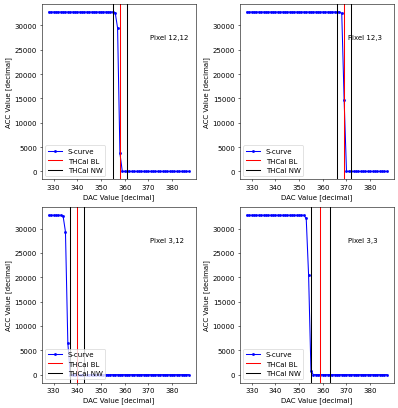

In [53]:
fig = plt.figure(dpi=50, figsize=(16,16))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.plot(DAC_range, ACC_map_Scurve[row][col], 'b.-', label="S-curve")
        ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', label="THCal NW")
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k')
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("ACC Value [decimal]")
        ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Qinj S Curve Scan + ACC scan

In [24]:
min_threshold = int(BL_map_THCal[row][col]-3*NW_map_THCal[row][col])
# min_threshold = 232
thresholds = {
    5: np.arange(min_threshold,  min_threshold + 60,  2),
    6: np.arange(min_threshold,  min_threshold + 60,  2),
    10: np.arange(min_threshold, min_threshold + 100, 2),
    15: np.arange(min_threshold, min_threshold + 130, 2),
    20: np.arange(min_threshold, min_threshold + 180, 2),
    25: np.arange(min_threshold, min_threshold + 220, 2),
    30: np.arange(min_threshold, min_threshold + 260, 2),
}
# thresholds = np.arange(233,450,2)
# thresholds = np.arange(451,500,2)
# thresholds = [10, 150, 240, 250, 260, 270, 280, 290, 300]
QInjEns = [5, 6, 10, 15, 20, 25, 30]
# QInjEns = [10, 15, 20, 25, 30]
# QInjEns = [30]

ACC_map_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds[q]} for q in QInjEns} for col in range(16)} for row in range(16)}

In [22]:
# old_ACC_map_full_Scurve = ACC_map_full_Scurve

# QInjEns = [5, 6, 10, 15, 20, 25, 30]
# thresholds = np.arange(int(BL_map_THCal[row][col]-3*NW_map_THCal[row][col]),300,2)

# ACC_map_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds} for q in QInjEns} for col in range(16)} for row in range(16)}

# for row in range(16):
#     for col in range(16):
#         for q in old_ACC_map_full_Scurve[row][col]:
#             for thresh in old_ACC_map_full_Scurve[row][col][q]:
#                 ACC_map_full_Scurve[row][col][q][thresh] = old_ACC_map_full_Scurve[row][col][q][thresh]

# print(ACC_map_full_Scurve[3][3])
# print(ACC_map_full_Scurve[3][3].keys())

In [29]:
row_list = [3]
col_list = [3]
scan_list = list(zip(col_list, row_list))
print(scan_list)
scan_name = "E2_testing_VRef_SCurve"
total_number_pixels = 1
time_per_pixel = 20
dead_time_per_pixel = 5
total_scan_time = total_number_pixels*(time_per_pixel + dead_time_per_pixel)


row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")

# Loop for enable/disable charge injection per pixel (single!!!)
for index, row, col in zip(tqdm(range(len(row_list)), desc=f'Pixel Loop', leave=True), row_list, col_list):  
    column_indexer_handle.set(col)
    row_indexer_handle.set(row)
    # Set current mode
    pixel_decoded_register_write("IBSel", format(0, '03b'))  # High current mode
    # pixel_decoded_register_write("IBSel", format(7, '03b'))  # Low current mode
    # Enable charge injection
    pixel_decoded_register_write("disDataReadout", "0")
    pixel_decoded_register_write("QInjEn", "1")
    # Bypass Cal Threshold
    # pixel_decoded_register_write("Bypass_THCal", "1")
    for QInj in tqdm(QInjEns, desc=f'Charge Loop for Pixel {col},{row}', leave=False):
        # Modifying charge injected
        pixel_decoded_register_write("QSel", format(QInj, '05b'))
        for DAC in tqdm(thresholds[QInj], desc=f'DAC Loop for Pixel {col},{row}', leave=False):
            threshold_name = scan_name+f'_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{DAC}'

            # Set the DAC value to the value being scanned
            pixel_decoded_register_write("DAC", format(DAC, '010b'))

            # Enable THCal clock and buffer, disable bypass
            pixel_decoded_register_write("CLKEn_THCal", "1")
            pixel_decoded_register_write("BufEn_THCal", "1")
            pixel_decoded_register_write("Bypass_THCal", "0")
            pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
            # Reset the calibration block (active low)
            pixel_decoded_register_write("RSTn_THCal", "0")
            pixel_decoded_register_write("RSTn_THCal", "1")
            # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
            pixel_decoded_register_write("ScanStart_THCal", "1")
            pixel_decoded_register_write("ScanStart_THCal", "0")
            # Check the calibration done correctly
            if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
            BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
            NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
            # Disable clock and buffer before charge injection 
            pixel_decoded_register_write("CLKEn_THCal", "0") 
            pixel_decoded_register_write("BufEn_THCal", "0")
            pixel_decoded_register_write("Bypass_THCal", "1")

            today = datetime.date.today()
            todaystr = "../ETROC-Data/" + today.isoformat() + "_Array_Test_Results/"

            tmp_dir = Path(todaystr+threshold_name)
            tmp_dir.mkdir(exist_ok=True)

            # np.save(todaystr+threshold_name+"/BL.npy", np.array([BL_map_THCal[row, col]]))
            # np.save(todaystr+threshold_name+"/NW.npy", np.array([NW_map_THCal[row, col]]))

            # Save BL, NW and relevant information together in pickle
            template = {
                'BL': BL_map_THCal[row, col],
                'NW': NW_map_THCal[row, col],
                'row': row,
                'col': col,
                'charge': QInj,
                'threshold': DAC,
                'time': datetime.datetime.now(),
            }
            with open(tmp_dir/'info.pkl', 'wb') as file:
                pickle.dump(template, file)
            
            parser = run_script.getOptionParser()
            (options, args) = parser.parse_args(args=f"--firmware --useIPC --hostname 192.168.2.3 -t {int(total_scan_time)} -o {threshold_name} -v -w --compressed_translation".split())
            IPC_queue = multiprocessing.Queue()
            process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, 'main_process'))
            process.start()

            # Start Qinj and L1A trains
            time.sleep(1)
            IPC_queue.put('start L1A train')
            while not IPC_queue.empty():
                pass

            # DAQ time
            time.sleep(time_per_pixel)

            # Stop DAQ fifo
            IPC_queue.put('stop DAQ')
            while not IPC_queue.empty():
                pass

            # Enable THCal clock and buffer and bypass
            pixel_decoded_register_write("CLKEn_THCal", "1")
            pixel_decoded_register_write("BufEn_THCal", "1")

            # Reset the calibration block (active low)
            pixel_decoded_register_write("RSTn_THCal", "0")
            pixel_decoded_register_write("RSTn_THCal", "1")

            # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
            pixel_decoded_register_write("ScanStart_THCal", "1")
            pixel_decoded_register_write("ScanStart_THCal", "0")
            # Fetch the status registers
            if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
            ACC_map_full_Scurve[row][col][QInj][DAC] = pixel_decoded_register_read("ACC", "Status", need_int=True)
            # Disable THCal clock and buffer and bypass
            pixel_decoded_register_write("CLKEn_THCal", "0")
            pixel_decoded_register_write("BufEn_THCal", "0")

            # Stop Qinj and L1A trains, join process
            IPC_queue.put('stop L1A train')
            while not IPC_queue.empty():
                pass
            IPC_queue.put('allow threads to exit')
            process.join()
    # Set the DAC value to the vpreviously found BL + Offset (7)
    pixel_decoded_register_write("DAC", format(int(BL_map_THCal[row,col]+7), '010b'))
    # Disable charge injection
    pixel_decoded_register_write("QInjEn", "0")
    pixel_decoded_register_write("disDataReadout", "1")

[(3, 3)]


Pixel Loop:   0%|          | 0/1 [00:00<?, ?it/s]






















































































































Pixel Loop:   0%|          | 0/1 [1:41:08<?, ?it/s]


KeyboardInterrupt: 

## ACC Plots

In [ ]:
fig = plt.figure(dpi=50, figsize=(16,16))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axvline(BL_map_THCal[row][col], color='r', label="THCal BL")
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', label="THCal NW")
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k')
        for QInj in QInjEns:
            ax0.plot(thresholds, ACC_map_full_Scurve[row][col][QInj].values(), '.-', label=f"{QInj} fC")
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("ACC Value [decimal]")
        ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## Counts

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from fnmatch import fnmatch

In [ ]:
#thresholds = np.arange(233,450,2)
#QInjEns = [5, 6, 10, 15, 20, 25, 30]
#threshold_dict ={QInj:(np.arange(233,450,2) if QInj > 6 else np.arange(233,300, 2)) if QInj!=30 else np.arange(233,500,2) for QInj in QInjEns}

In [ ]:
root = '../ETROC-Data'
file_pattern = "*translated*.dat"
hitmap_full_Scurve = {row:{col:{q:{thr:0 for thr in thresholds[q]} for q in QInjEns} for col in range(16)} for row in range(16)}
for index, row, col in zip((range(len(row_list))), row_list, col_list):
    for QInj in (QInjEns):
        for DAC in (thresholds[QInj]):
            print(f'Pixel {col},{row} - {QInj} fC - DAC {DAC}')
            path_pattern = f"*2023-06-09_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C{col}_R{row}_QInj_{QInj}_Threshold_{DAC}"
            file_list = []
            for path, subdirs, files in os.walk(root):
                if not fnmatch(path, path_pattern): continue
                for name in files:
                    pass
                    if fnmatch(name, file_pattern):
                        file_list.append(os.path.join(path, name))
                        print(file_list[-1])
            current_bcid = -1
            previous_bcid = -1
            total_files = len(file_list)
            for file_index, file_name in enumerate(file_list):
                print(f"{file_index+1}/{total_files}")
                with open(file_name) as infile:
                    for line in infile:
                        text_list = line.split()
                        if(text_list[2]=="HEADER"): current_bcid = int(text_list[8])
                        elif(text_list[2]=="TRAILER"): previous_bcid = current_bcid
                        if(previous_bcid==-1 or (current_bcid-previous_bcid<=68 if current_bcid>=previous_bcid else current_bcid+3564-previous_bcid<=68)): continue
                        if text_list[2]!="DATA": continue
                        c_running = int(text_list[6])
                        r_running = int(text_list[8])
                        hitmap_full_Scurve[r_running][c_running][QInj][DAC] += 1 

In [ ]:
fig = plt.figure(dpi=200, figsize=(8,4.5))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axvline(BL_map_THCal[row][col], color='k', label="THCal BL", lw=0.7)
        ax0.axvline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label="THCal NW", lw=0.7)
        ax0.axvline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
        for QInj in QInjEns[0:]:
            ax0.plot(thresholds[QInj], hitmap_full_Scurve[row][col][QInj].values(), '.-', label=f"{QInj} fC",lw=0.5,markersize=2)
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("Data Counts [decimal]")
        # ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="center right")
plt.title(f"Bare Chip 01E2 #52, Pixel ({row},{col}) Full S-Curve")
plt.tight_layout()
plt.show()

In [ ]:
def find_largest_non_zero_idx(array, key_array):
    array = np.array(list(array))
    np_key = np.where(array!=0, key_array, 0)
    return key_array[np.argmax(np_key)]

In [ ]:
fig = plt.figure(dpi=200, figsize=(8,4.5))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
u_cl = np.sort(np.unique(col_list))
u_rl = np.sort(np.unique(row_list))
for ri,row in enumerate(u_rl):
    for ci,col in enumerate(u_cl):
        ax0 = fig.add_subplot(gs[len(u_rl)-ri-1,len(u_cl)-ci-1])
        ax0.axhline(BL_map_THCal[row][col], color='k', label="THCal BL", lw=0.7)
        ax0.axhline(BL_map_THCal[row][col]+NW_map_THCal[row][col], color='k', ls='--', label="THCal NW", lw=0.7)
        ax0.axhline(BL_map_THCal[row][col]-NW_map_THCal[row][col], color='k', ls='--', lw=0.7)
        X = []
        Y = []
        for QInj in QInjEns[0:]:
            tp_thr = find_largest_non_zero_idx(hitmap_full_Scurve[row][col][QInj].values(), thresholds[QInj])
            X.append(QInj)
            Y.append(tp_thr)
        ax0.plot(X, Y,'ro')
        m, b = np.polyfit(X, Y, 1)
        topEdge = BL_map_THCal[row][col]+NW_map_THCal[row][col]
        min_charge = (topEdge - b)/m
        ax0.plot(np.linspace(min_charge,30,100), b + m*np.linspace(min_charge,30,100), 'b-', label=f'DAC = {m:.3f}Q + {b:.3f}')
        ax0.set_xlabel("Charge Injected (Allegedly) [fC]")
        ax0.set_ylabel("DAC Threshold [decimal]")
        plt.legend(loc="center right")
plt.title(f"Bare Chip 01E2 #52, Pixel ({row},{col}) Full S-Curve, PA Low Bias Current Mode")
plt.tight_layout()
plt.show()

In [ ]:
print(Y)

In [ ]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# Loop for threshold calibration
for row in [3]:
    for col in [3]:
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))

## Disconnect chip

In [ ]:
conn.disconnect()

In [ ]:
np.load("/home/daq/ETROC2/ETROC-Data/2023-06-12_Array_Test_Results/E2_testing_VRef_SCurve_Pixel_C3_R3_QInj_5_Threshold_234/NW.npy")

array([262.])